## This notebook simulates a flock of birds using the Boid model

#### create the dataset in pytorch format
Positions: (rollout steps ahead, number of boids, 2)
ex: (100 frames, 20 boids, 2 dimensions)

Species: a list of num_boid entries of each boid’s identity, (number of boids)
ex: ['goose', 'goose', 'crane', 'crane', 'crane']

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import torch
from torch_geometric.data import DataLoader

In [35]:
import sys
import os
script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [36]:
import os

from collab_env.data.file_utils import expand_path, get_project_root

# our code
from collab_env.sim.boids_gnn_temp.animal_simulation import (
    AnimalTrajectoryDataset,
    visualize_graph,
)
from collab_env.sim.boids_gnn_temp.boid import init_multi_species_boids, update_boids

# %%


smoke_test = "CI" in os.environ

steps = 1000 if not smoke_test else 10
# %%

In [41]:
50/480

0.10416666666666667

In [40]:
species_configs = {  # different spieces should have a different set of values for all the parameters
    # but the parameter name should all be the same for one updating algorithms.
    "A": {
        "visual_range": 50,
        "centering_factor": 0.005,
        "min_distance": 15,
        "avoid_factor": 0.05,
        "matching_factor": 0.5,
        "margin": 5,  # 0.05, 25
        "turn_factor": 10,
        "speed_limit": 7,
        "counts": 20,
        "independent": False
    }
}

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=480,
    height=480,
    steps=steps,
    num_samples=50,
    seed=2025,
)

torch.save(
    dataset,
    expand_path("simulated_data/boid_single_species_basic.pt", get_project_root()),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_basic_config.pt", get_project_root()
    ),
)

### weak alignment

In [38]:
species_configs["A"]["matching_factor"] = 0.1

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=480,
    height=480,
    steps=steps,
    num_samples=50,
    seed=2025,
)

torch.save(
    dataset,
    expand_path("simulated_data/boid_single_species_weak_alignment.pt", get_project_root()),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_weak_alignment_config.pt", get_project_root()
    ),
)

### strong alignment

In [39]:
species_configs["A"]["matching_factor"] = 1

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=480,
    height=480,
    steps=steps,
    num_samples=50,
    seed=2025,
)

torch.save(
    dataset,
    expand_path("simulated_data/boid_single_species_strong_alignment.pt", get_project_root()),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_strong_alignment_config.pt", get_project_root()
    ),
)

### independent

In [21]:
species_configs = {  # different spieces should have a different set of values for all the parameters
    # but the parameter name should all be the same for one updating algorithms.
    "A": {
        "visual_range": 50,
        "centering_factor": 0.005,
        "min_distance": 15,
        "avoid_factor": 0.05,
        "matching_factor": 0.5,
        "margin": 5,  # 0.05, 25
        "turn_factor": 10,
        "speed_limit": 7,
        "counts": 20,
        "independent": True
    }
}

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=480,
    height=480,
    steps=steps,
    num_samples=50,
    seed=2025,
)

torch.save(
    dataset,
    expand_path("simulated_data/boid_single_species_independent.pt", get_project_root()),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_independent_config.pt", get_project_root()
    ),
)

### Short version

In [7]:
species_configs = {  # different spieces should have a different set of values for all the parameters
    # but the parameter name should all be the same for one updating algorithms.
    "A": {
        "visual_range": 50,
        "centering_factor": 0.005,
        "min_distance": 15,
        "avoid_factor": 0.05,
        "matching_factor": 0.5,
        "margin": 5,  # 0.05, 25
        "turn_factor": 10,
        "speed_limit": 20,
        "counts": 20,
    }
}

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=640,
    height=480,
    steps=10,
    num_samples=50,
    seed=2025,
)

torch.save(
    dataset,
    expand_path("simulated_data/boid_single_species_short.pt", get_project_root()),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_short_config.pt", get_project_root()
    ),
)

### A bit faster flying bird

In [8]:
velocity_scale = 30

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=640,
    height=480,
    steps=steps,
    num_samples=50,
    velocity_scale=velocity_scale,
    seed=2026,
)  # 50 videos of 1000 frames (5 steps advanced forward) each

torch.save(
    dataset,
    expand_path(
        "simulated_data/boid_single_species_high_cluster_high_speed.pt",
        get_project_root(),
    ),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_high_cluster_high_speed_config.pt",
        get_project_root(),
    ),
)

### Noisy birds

In [9]:
species_configs["A"]["matching_factor"] = 0.1


dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=640,
    height=480,
    steps=steps,
    num_samples=50,
    seed=2025,
)
torch.save(
    dataset,
    expand_path("simulated_data/boid_single_species_noisy.pt", get_project_root()),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_noisy_config.pt", get_project_root()
    ),
)

### Plot data

In [30]:
#file_name = 'boid_food_basic_alignment.pt'
#config_name = 'boid_food_basic_alignment_config.pt'

file_name = 'boid_single_species_basic.pt'
config_name = 'boid_single_species_basic_config.pt'

#file_name = 'boid_single_species_independent.pt'
#config_name = 'boid_single_species_independent_config.pt'

dataset = torch.load(expand_path(
        "simulated_data/" + file_name, get_project_root()), weights_only = False)
species_configs = torch.load(expand_path(
        "simulated_data/" + config_name, get_project_root()), weights_only = False)

In [31]:
batch_size = 1
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

batch = next(iter(loader))
p, species = batch

print("made", str(len(list(loader))), "batches, each of size", str(batch_size))  #
print("Positions:", p.shape)  # [B, steps, N, 2]
print("Species labels:", species.shape)  # [B, N]
print("\n")

made 50 batches, each of size 1
Positions: torch.Size([1, 1000, 20, 2])
Species labels: torch.Size([1, 20])




### Visualize boids

p0 shape torch.Size([20, 2])
p shape torch.Size([1000, 20, 2])


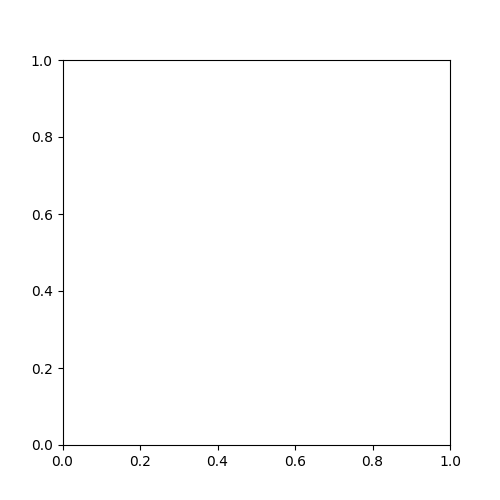

In [32]:
%matplotlib widget
global ani

file_id = 7
batch = list(iter(loader))[file_id]
p, species = batch
v = torch.diff(p, axis = 1) 

_, F, _2, dim = p.shape
starting_frame = int(round(3*F/4))
ani, _ = visualize_graph(p[0,:], v[0], species = species, batch = None, starting_frame = 0, file_id = 0, ending_frame = 1000)